In [1]:
# Helper functions for preprocessing raw text before feeding it into a Neural Net
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Map printable characters to ints and vice-versa
ALPHABET = string.printable

char2int = dict((c, i) for i, c in enumerate(ALPHABET))
int2char = dict((i, c) for i, c in enumerate(ALPHABET))


def c2i(char):
    return char2int[char]

def i2c(num):
    return int2char[num]


def vectorize_text(text):
    """Convert a text into integers"""
    X = []
    text = ''.join(list(filter(lambda x: x in ALPHABET, text)))
    X = [c2i(char) for char in text]
    X = np.array(X)
    X = X / float(len(ALPHABET))
    return X

In [2]:
print(vectorize_text([ALPHABET]).shape)
# print(len(ALPHABET))
# print(ALPHABET[-1])

(100,)


In [3]:
import os
from spacy.en import English
nlp = English()

class TextPair:
    def __init__(self, author, known, unknown, max_length=1200):
        self.author = author
        self.known = known
        self.unknown = unknown
        self.max_length = max_length

def get_string(filename):
    with open(filename, encoding="utf8") as f:
        s = f.read()
    return s

def get_texts(directory):
    authors = [x for x in os.listdir(directory) if x.startswith("E")]
    tps = []
    for author in authors:
        known = os.path.join(directory, author, "known01.txt")
        unknown = os.path.join(directory, author, "unknown.txt")
        ktext = get_string(known)
        utext = get_string(unknown)
        
        kparsed = 
        
        tps.append(TextPair(author, get_string(known), get_string(unknown)))
    return tps

def get_data(directory):
    # read all texts into known, unknown pairs
    tps = get_texts(directory)
    
    # get labels
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    y = np.array(y)
    return tps, y
    


    
    # create pairs


SyntaxError: invalid syntax (<ipython-input-3-04d63ecbc4cc>, line 26)

In [4]:
pan15train = "/data/pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "/data/pan15-authorship-verification-test-dataset2-english-2015-04-19/"
# pan15train = "/data/emails-train/"
# pan15test = "/data/emails-test/"

pan14train = "/data/pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14test = "/data/pan14-author-verification-test-corpus2-english-essays-2014-04-22/"

# pan14train = "/data/pan14-author-verification-training-corpus-english-novels-2014-04-22/"
# pan14test = "/data/pan14-author-verification-test-corpus2-english-novels-2014-04-22/"


te_pairs, te_y = get_data(pan15test)
tr_pairs, tr_y = get_data(pan15train)

char_tf = TfidfVectorizer(analyzer='char', ngram_range=(2,4), min_df=0.3)
word_tf = TfidfVectorizer(ngram_range=(1,2), min_df=0.05)
vec = FeatureUnion([
    ('char', char_tf),
    ('word', word_tf)
])
vec.fit([tp.known for tp in te_pairs] + [tp.unknown for tp in te_pairs] +
         [tp.known for tp in tr_pairs] + [tp.unknown for tp in tr_pairs])


def normalize(text, target_length=1200):
    if len(text) > target_length:
        return text[:target_length]
    else:
        return text + ("$" * (target_length - len(text)))

def vectorize(texts, vec, target_length=1200):
    # texts = [normalize(text) for text in texts]
    return vec.transform(texts)
    

NameError: name 'get_data' is not defined

In [5]:
train_known_X = vectorize([tp.known for tp in tr_pairs], vec)
train_unknown_X = vectorize([tp.unknown for tp in tr_pairs], vec)

NameError: name 'vectorize' is not defined

In [6]:
test_known_X = vectorize([tp.known for tp in te_pairs], vec)
test_unknown_X = vectorize([tp.unknown for tp in te_pairs], vec)

NameError: name 'vectorize' is not defined

In [7]:
train_known_X = train_known_X.todense()
train_unknown_X = train_unknown_X.todense()
test_known_X = test_known_X.todense()
test_unknown_X = test_unknown_X.todense()

NameError: name 'train_known_X' is not defined

In [8]:
def create_pairs(knownX, unknownX):
    pairs = []
    for i in range(knownX.shape[0]):
        pairs += [[knownX[i], unknownX[i]]]
    pairs = np.array(pairs)
    print(pairs.shape)
    return pairs

In [9]:
tr_pairs = create_pairs(train_known_X, train_unknown_X)
te_pairs = create_pairs(test_known_X, test_unknown_X)

NameError: name 'train_known_X' is not defined

In [10]:
tr_pairs = tr_pairs.squeeze()
te_pairs = te_pairs.squeeze()

NameError: name 'tr_pairs' is not defined

In [13]:
tr_pairs.shape

(100, 2, 4187)

In [60]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(256, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))

    return seq

def create_base_network_2(input_dim):
    '''
    Base network for feature extraction.
    '''
    inputs = Input(shape=(input_dim, ))
    dense1 = Dense(128)(inputs)
    bn1 = BatchNormalization()(dense1)
    relu1 = Activation('relu')(bn1)

    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization()(dense2)
    res2 = merge([relu1, bn2], mode='sum')
    relu2 = Activation('relu')(res2)    

    dense3 = Dense(128)(relu2)
    bn3 = BatchNormalization()(dense3)
    res3 = Merge(mode='sum')([relu2, bn3])
    relu3 = Activation('relu')(res3)   
    
    feats = merge([relu3, relu2, relu1], mode='concat')
    bn4 = BatchNormalization(mode=2)(feats)
    return inputs, bn4

def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

In [70]:
input_dim = tr_pairs.shape[-1]

# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [71]:
# train
"""
tr_pairs1 = tr_pairs[:250]
te_pairs1 = tr_pairs[250:]
tr_y1 = tr_y[:250]
te_y1 = tr_y[250:]

tr_pairs = tr_pairs1
te_pairs = te_pairs1
tr_y = tr_y1
te_y = te_y1
"""
# tr_pairs = np.vstack([tr_pairs, te_pairs])
# print(tr_pairs.shape)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_split=0.3,
          batch_size=10,
          epochs=20)



Train on 70 samples, validate on 30 samples
Epoch 1/20
70/70 [==============================] - 0s - loss: 0.2600 - val_loss: 0.1816
Epoch 2/20
70/70 [==============================] - 0s - loss: 0.0842 - val_loss: 0.1693
Epoch 3/20
70/70 [==============================] - 0s - loss: 0.0343 - val_loss: 0.1593
Epoch 4/20
70/70 [==============================] - 0s - loss: 0.0140 - val_loss: 0.1474

In [72]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 95.00%
* Accuracy on test set: 72.20%


In [73]:
from collections import Counter
from sklearn.metrics import classification_report
preds = [1 if p[0] < 0.5 else 0 for p in pred]
print(Counter(preds))
print(classification_report(te_y, preds))

Counter({1: 379, 0: 121})
             precision    recall  f1-score   support

          0       0.96      0.46      0.63       250
          1       0.65      0.98      0.78       250

avg / total       0.80      0.72      0.70       500



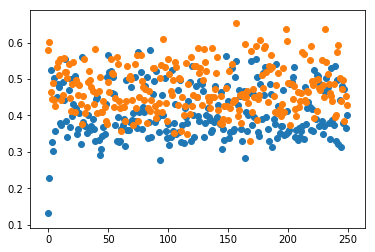

In [74]:
from scipy.spatial.distance import euclidean, cosine
%matplotlib inline
from matplotlib import pyplot as plt

def plot(tr_pairs, tr_y):
    eucs = [euclidean(tr_pairs[i][0], tr_pairs[i][1]) for i in range(len(tr_pairs))]
    coss = [cosine(tr_pairs[i][0], tr_pairs[i][1]) for i in range(len(tr_pairs))]



    same = [x for i, x in enumerate(coss) if tr_y[i]]
    diff = [x for i, x in enumerate(coss) if not tr_y[i]]
    plt.scatter(range(len(same)), same)
    plt.scatter(range(len(same)), diff)
    plt.show()
    return eucs, coss

e, c = plot(te_pairs, te_y)

In [19]:
eucs[0]

NameError: name 'eucs' is not defined

In [20]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cross_val_score(DecisionTreeClassifier(), [[x] for x in coss], tr_y)

NameError: name 'coss' is not defined

In [21]:
tr_pairs.shape

(100, 2, 4187)

In [22]:
te_pairs[:,0].shape

(500, 4187)

In [23]:
np.hstack([tr_y,te_y])

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1,